In [1]:
from IPython.display import clear_output
!pip install imutils
!pip install -q efficientnet
clear_output()

In [2]:
import numpy as np 
import tensorflow as tf
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
import sklearn as sk
import tensorflow
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, f1_score

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras import layers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, Callback


init_notebook_mode(connected=True)
RANDOM_SEED = 333
clear_output()

In [3]:
!apt-get install tree
clear_output()
!mkdir TRAIN TEST VAL TEST_BMI TEST_BDB TEST_BMD TRAIN/YES TRAIN/NO TEST/YES TEST/NO VAL/YES VAL/NO TEST_BMI/YES TEST_BMI/NO TEST_BDB/YES TEST_BDB/NO TEST_BMD/YES TEST_BMD/NO 
!tree -d

.
├── TEST
│   ├── NO
│   └── YES
├── TEST_BDB
│   ├── NO
│   └── YES
├── TEST_BMD
│   ├── NO
│   └── YES
├── TEST_BMI
│   ├── NO
│   └── YES
├── TRAIN
│   ├── NO
│   └── YES
└── VAL
    ├── NO
    └── YES

18 directories


In [4]:
CLASS_list = ['no','yes']
IMG_PATH = '../input/brain-tumor-detection'
print(os.listdir(IMG_PATH))
print(CLASS_list)

['no', 'yes', 'Br35H-Mask-RCNN', 'pred']
['no', 'yes']


In [5]:
IMG_PATH = '../input/brain-tumor-detection/'

for CLASS in CLASS_list:
    if (not CLASS.startswith('.') and (not CLASS.startswith('pred'))):
        print(IMG_PATH + '     ' + CLASS)
        IMG_NUM = len(os.listdir(IMG_PATH + CLASS))
        for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH + CLASS)):
            img = IMG_PATH + CLASS + '/' + FILE_NAME
            if n < 200:
                shutil.copy(img, 'TEST/' + CLASS.upper() + '/' + FILE_NAME)
            elif n < 1200:
                shutil.copy(img, 'TRAIN/'+ CLASS.upper() + '/' + FILE_NAME)
            else:
                shutil.copy(img, 'VAL/'+ CLASS.upper() + '/' + FILE_NAME)

../input/brain-tumor-detection/     no
../input/brain-tumor-detection/     yes


In [6]:
IMG_PATH = '../input/brain-mri-images-for-brain-tumor-detection'
for CLASS in CLASS_list:
    if not CLASS.startswith('.'):
        IMG_NUM = len(os.listdir(IMG_PATH + '/' + CLASS))
        for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH + '/' + CLASS)):
            img = IMG_PATH + '/' + CLASS + '/' + FILE_NAME
            if n < 500:
                shutil.copy(img, 'TEST_BMI/' + CLASS.upper() + '/' + FILE_NAME)

In [7]:
def load_data(dir_path, img_size=(100,100)):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels



def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

In [8]:
TRAIN_DIR = 'TRAIN/'
TEST_DIR = 'TEST/'
VAL_DIR = 'VAL/'
TEST_BMI_DIR = 'TEST_BMI/'
TEST_BMD_DIR = 'TEST_BMD/'
TEST_BDB_DIR = 'TEST_BDB/'
IMG_SIZE = (224,224)
X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)
X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)
X_test_bmi, y_test_bmi, _ = load_data(TEST_BMI_DIR, IMG_SIZE)
X_test_bmd, y_test_bmd, _ = load_data(TEST_BMD_DIR, IMG_SIZE)
X_test_bdb, y_test_bdb, _ = load_data(TEST_BDB_DIR, IMG_SIZE)

100%|██████████| 2/2 [00:03<00:00,  1.84s/it]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



2000 images loaded from TRAIN/ directory.


100%|██████████| 2/2 [00:00<00:00,  2.95it/s]


400 images loaded from TEST/ directory.


100%|██████████| 2/2 [00:01<00:00,  1.99it/s]


600 images loaded from VAL/ directory.


100%|██████████| 2/2 [00:00<00:00,  3.50it/s]


253 images loaded from TEST_BMI/ directory.


100%|██████████| 2/2 [00:00<00:00, 1690.91it/s]


0 images loaded from TEST_BMD/ directory.


100%|██████████| 2/2 [00:00<00:00, 1999.19it/s]

0 images loaded from TEST_BDB/ directory.


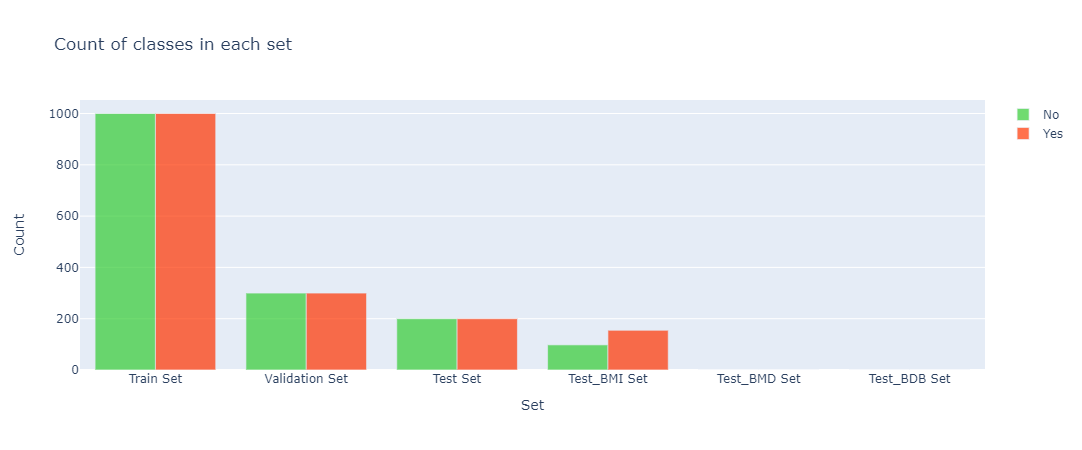

In [9]:
y = dict()
y[0] = []
y[1] = []
for set_name in (y_train, y_val, y_test, y_test_bmi, y_test_bmd, y_test_bdb):
    y[0].append(np.sum(set_name == 0))
    y[1].append(np.sum(set_name == 1))

trace0 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set', 'Test_BMI Set', 'Test_BMD Set', 'Test_BDB Set'],
    y=y[0],
    name='No',
    marker=dict(color='#33cc33'),
    opacity=0.7
)
trace1 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set', 'Test_BMI Set', 'Test_BMD Set', 'Test_BDB Set'],
    y=y[1],
    name='Yes',
    marker=dict(color='#ff3300'),
    opacity=0.7
)
data = [trace0, trace1]
layout = go.Layout(
    title='Count of classes in each set',
    xaxis={'title': 'Set'},
    yaxis={'title': 'Count'}
)
fig = go.Figure(data, layout)
iplot(fig)

In [10]:
def plot_samples(X, y, labels_dict, n=50):
    """
    Creates a gridplot for desired number of images (n) from the specified set
    """
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(15,6))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Tumor: {}'.format(labels_dict[index]))
        plt.show()

In [11]:
plot_samples(X_test_bdb, y_test_bdb, labels, 10)

<Figure size 1080x432 with 0 Axes>

<Figure size 1080x432 with 0 Axes>

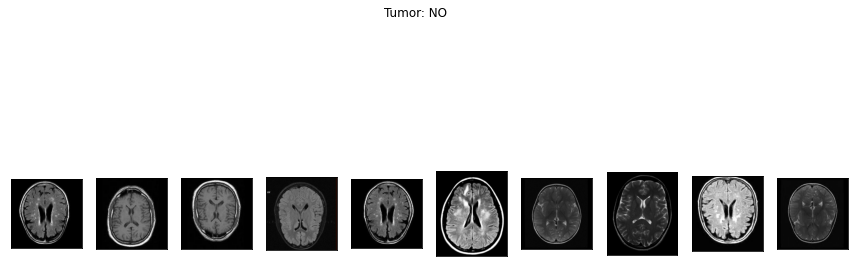

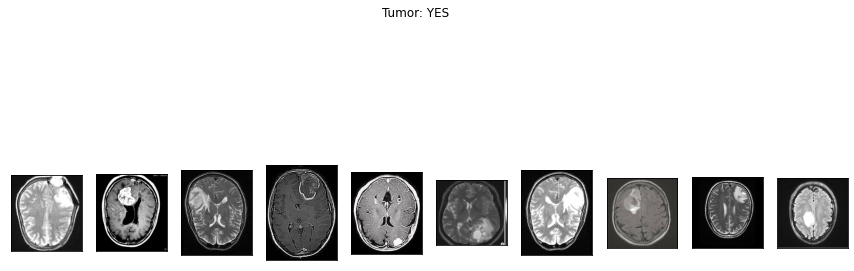

In [12]:
plot_samples(X_train, y_train, labels, 10)

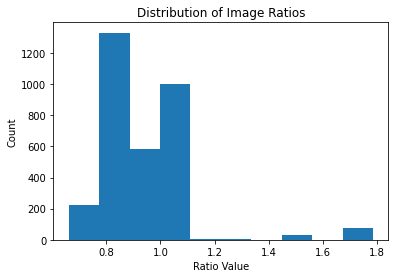

In [13]:
RATIO_LIST = []
for set in (X_train, X_test, X_val, X_test_bmi, X_test_bdb, X_test_bmd):
    for img in set:
        RATIO_LIST.append(img.shape[1]/img.shape[0])
        
plt.hist(RATIO_LIST)
plt.title('Distribution of Image Ratios')
plt.xlabel('Ratio Value')
plt.ylabel('Count')
plt.show()

In [14]:
class HomomorphicFilter:
    """Homomorphic filter implemented with diferents filters and an option to an external filter.
    
    High-frequency filters implemented:
        butterworth
        gaussian
    Attributes:
        a, b: Floats used on emphasis filter:
            H = a + b*H
     
       .
    """

    def __init__(self, a = 0.5, b = 1.5):
        self.a = float(a)
        self.b = float(b)

    # Filters
    def __butterworth_filter(self, I_shape, filter_params):
        P = I_shape[0]/2
        Q = I_shape[1]/2
        U, V = np.meshgrid(range(I_shape[0]), range(I_shape[1]), sparse=False, indexing='ij')
        Duv = (((U-P)**2+(V-Q)**2)).astype(float)
        H = 1/(1+(Duv/filter_params[0]**2)**filter_params[1])
        return (1 - H)

    def __gaussian_filter(self, I_shape, filter_params):
        P = I_shape[0]/2
        Q = I_shape[1]/2
        H = np.zeros(I_shape)
        U, V = np.meshgrid(range(I_shape[0]), range(I_shape[1]), sparse=False, indexing='ij')
        Duv = (((U-P)**2+(V-Q)**2)).astype(float)
        H = np.exp((-Duv/(2*(filter_params[0])**2)))
        return (1 - H)

    # Methods
    def __apply_filter(self, I, H):
        H = np.fft.fftshift(H)
        I_filtered = (self.a + self.b*H)*I
        return I_filtered

    def filter(self, I, filter_params, filter='butterworth', H = None):
        """
        Method to apply homormophic filter on an image
        Attributes:
            I: Single channel image
            filter_params: Parameters to be used on filters:
                butterworth:
                    filter_params[0]: Cutoff frequency 
                    filter_params[1]: Order of filter
                gaussian:
                    filter_params[0]: Cutoff frequency
            filter: Choose of the filter, options:
                butterworth
                gaussian
                external
            H: Used to pass external filter
        """

        #  Validating image
        if len(I.shape) is not 2:
            raise Exception('Improper image')

        # Take the image to log domain and then to frequency domain 
        I_log = np.log1p(np.array(I, dtype="float"))
        I_fft = np.fft.fft2(I_log)

        # Filters
        if filter=='butterworth':
            H = self.__butterworth_filter(I_shape = I_fft.shape, filter_params = filter_params)
        elif filter=='gaussian':
            H = self.__gaussian_filter(I_shape = I_fft.shape, filter_params = filter_params)
        elif filter=='external':
            print('external')
            if len(H.shape) is not 2:
                raise Exception('Invalid external filter')
        else:
            raise Exception('Selected filter not implemented')
        
        # Apply filter on frequency domain then take the image back to spatial domain
        I_fft_filt = self.__apply_filter(I = I_fft, H = H)
        I_filt = np.fft.ifft2(I_fft_filt)
        I = np.exp(np.real(I_filt))-1
        return np.uint8(I)

In [15]:
kernel = np.array([[0, -1, 0],
                   [-1, 5,-1],
                   [0, -1, 0]])
kernel_2 = np.array([[-1, -1, -1],
                    [-1, 9,-1],
                    [-1, -1, -1]])

kernel_3 = np.array([[1, 1, 1],
                    [1, -7, 1],
                    [1, 1, 1]])

kernel_4 = np.array([[-1, -1, -1, -1, -1],
                    [-1, 2, 2, 2, -1],
                    [-1, 2, 8, 2, -1],
                    [-1, 2, 2, 2, -1],
                    [-1, -1, -1, -1, -1]]) / 8.0

In [16]:
def preprocessing_imgs(set_name, add_pixels_value=0):
    """
    Finds the extreme points on the image and crops the rectangular out of them
    
    """
    set_new = []
    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])
        
        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        new_img = cv2.cvtColor(new_img, cv2.COLOR_RGB2GRAY) #-transfer to grayscale
        #homo_filter = HomomorphicFilter(a = 0.9, b = 1.4) 
        #new_img = homo_filter.filter(I=new_img, filter_params=[30,2])
        #new_img = cv2.filter2D(src=img, ddepth=-1, kernel=kernel)
        new_img = cv2.equalizeHist(new_img) #-equalizing the intensity histogram
        new_img = cv2.cvtColor(new_img,cv2.COLOR_GRAY2RGB)
        set_new.append(new_img)

    return np.array(set_new)

In [19]:
X_train_crop = preprocessing_imgs(set_name=X_train)
X_val_crop = preprocessing_imgs(set_name=X_val)
X_test_crop = preprocessing_imgs(set_name=X_test)
X_test_bmi_crop = preprocessing_imgs(set_name=X_test_bmi)
X_test_bmd_crop = preprocessing_imgs(set_name=X_test_bmd)
X_test_bdb_crop = preprocessing_imgs(set_name=X_test_bdb )

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:38: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



In [20]:
def save_new_images(x_set, y_set, folder_name):
    i = 0
    for (img, imclass) in zip(x_set, y_set):
        if imclass == 0:
            cv2.imwrite(folder_name+'NO/'+str(i)+'.jpg', img)
        else:
            cv2.imwrite(folder_name+'YES/'+str(i)+'.jpg', img)
        i += 1

In [21]:
!mkdir TRAIN_CROP TEST_CROP VAL_CROP TEST_BMI_CROP TEST_BDB_CROP TEST_BMD_CROP TRAIN_CROP/YES TRAIN_CROP/NO TEST_CROP/YES TEST_CROP/NO VAL_CROP/YES VAL_CROP/NO TEST_BMI_CROP/YES TEST_BMI_CROP/NO TEST_BDB_CROP/YES TEST_BDB_CROP/NO TEST_BMD_CROP/YES TEST_BMD_CROP/NO

save_new_images(X_train_crop, y_train, folder_name='TRAIN_CROP/')
save_new_images(X_val_crop, y_val, folder_name='VAL_CROP/')
save_new_images(X_test_crop, y_test, folder_name='TEST_CROP/')
save_new_images(X_test_bmi_crop, y_test_bmi, folder_name='TEST_BMI_CROP/')
save_new_images(X_test_bmd_crop, y_test_bmd, folder_name='TEST_BMD_CROP/')
save_new_images(X_test_bdb_crop, y_test_bdb, folder_name='TEST_BDB_CROP/' ) 

In [22]:
def resize_imgs(set_name, img_size):
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        set_new.append(preprocess_input(img))
    return np.array(set_new)

In [23]:
X_train_crop_prep = resize_imgs(set_name=X_train_crop, img_size=IMG_SIZE)
X_test_crop_prep = resize_imgs(set_name=X_test_crop, img_size=IMG_SIZE)
X_val_crop_prep = resize_imgs(set_name=X_val_crop, img_size=IMG_SIZE)
X_test_bmi_crop_prep = resize_imgs(set_name=X_test_bmi_crop, img_size=IMG_SIZE)
X_test_bdb_crop_prep = resize_imgs(set_name=X_test_bdb_crop, img_size=IMG_SIZE)
X_test_bmd_crop_prep = resize_imgs(set_name=X_test_bmd_crop, img_size=IMG_SIZE)

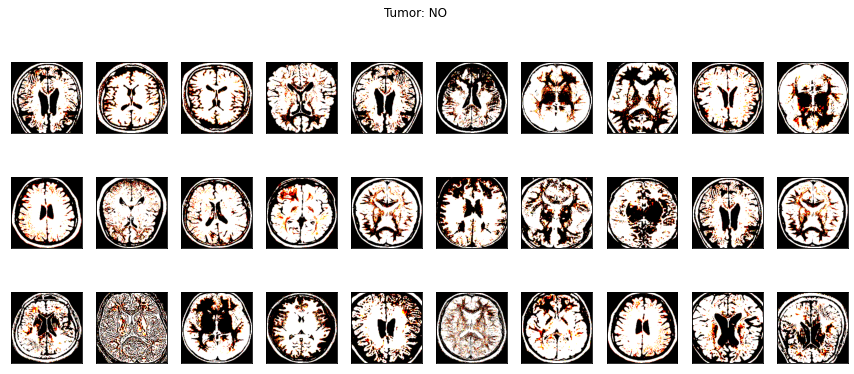

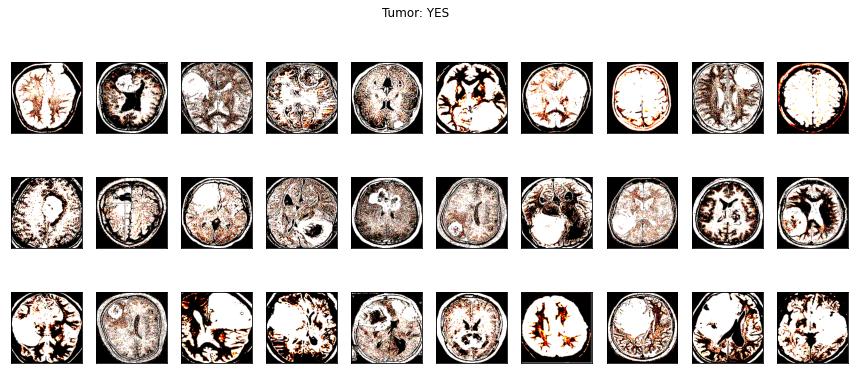

In [24]:
 plot_samples(X_train_crop_prep, y_train, labels, 30)

In [25]:
demo_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    rescale=1./255,
    shear_range=0.05,
    brightness_range=[0.1, 1.5],
    horizontal_flip=False,
    vertical_flip=False
)

In [26]:
os.mkdir('preview')
x = X_train_crop[0]  
x = x.reshape((1,) + x.shape) 

i = 0
for batch in demo_datagen.flow(x, batch_size=1, save_to_dir='preview', save_prefix='aug_img', save_format='jpg'):
    i += 1
    if i > 20:
        break 

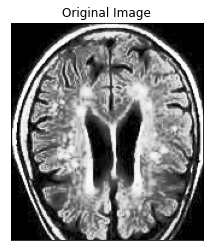

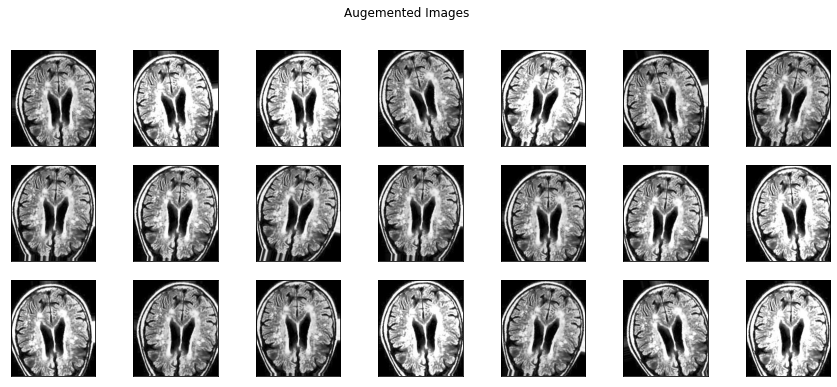

In [27]:
plt.imshow(X_train_crop[0])
plt.xticks([])
plt.yticks([])
plt.title('Original Image')
plt.show()

plt.figure(figsize=(15,6))
i = 1
for img in os.listdir('preview/'):
    img = cv2.cv2.imread('preview/' + img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3,7,i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    i += 1
    if i > 3*7:
        break
plt.suptitle('Augemented Images')
plt.show()

In [28]:
!rm -rf preview/

In [29]:
TRAIN_DIR = 'TRAIN_CROP/'
VAL_DIR = 'VAL_CROP/'

train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=False,
    vertical_flip=False,
    preprocessing_function=preprocess_input
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)


train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED
)


validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='binary',
    seed=RANDOM_SEED
)

Found 2000 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


In [30]:
import tensorflow.keras.layers as L

In [31]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping,TensorBoard, ReduceLROnPlateau
es = EarlyStopping(monitor='val_acc', mode='max', verbose=1, patience=5)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.3, patience=2, min_denta=0.0001, mode='auto', verbose=1)
tensorboard = TensorBoard(log_dir='logs')
checkpoint = ModelCheckpoint("EfficientNetB2_cropping+equalization.h5", monitor='val_accuracy', save_best_only=True, mode='auto', verbose=1)

In [32]:
import efficientnet.tfkeras as efn
NUM_CLASSES = 1

efficientnet = tf.keras.Sequential([
    efn.EfficientNetB2(
        input_shape=(224, 224, 3),
        weights='imagenet',
        include_top=False
    ),
    L.GlobalMaxPooling2D(),
    L.Dropout(rate=0.2),
    L.Dense(NUM_CLASSES, activation='sigmoid')
    ])
        
efficientnet.compile(
    optimizer='adam',
    loss = 'binary_crossentropy',
    metrics=['accuracy']
)
    
efficientnet.summary()

31948800/31936256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b2 (Functional) (None, 7, 7, 1408)        7768562   
_________________________________________________________________
global_max_pooling2d (Global (None, 1408)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1408)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1409      
Total params: 7,769,971
Trainable params: 7,702,403
Non-trainable params: 67,568
_________________________________________________________________


In [33]:
import time

start = time.time()

efficientnet_history = efficientnet.fit_generator(
    train_generator,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=30,
    callbacks=[es,tensorboard, checkpoint, reduce_lr]
    )

end = time.time()
print(end - start)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning:

Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.



Epoch 1/30
63/63 [==============================] - 53s 536ms/step - loss: 0.6134 - accuracy: 0.8660 - val_loss: 0.4799 - val_accuracy: 0.8062

Epoch 00001: val_accuracy improved from -inf to 0.80625, saving model to EfficientNetB2_cropping+equalization.h5
Epoch 2/30
63/63 [==============================] - 31s 491ms/step - loss: 0.1191 - accuracy: 0.9655 - val_loss: 0.2923 - val_accuracy: 0.9542

Epoch 00002: val_accuracy improved from 0.80625 to 0.95417, saving model to EfficientNetB2_cropping+equalization.h5
Epoch 3/30
63/63 [==============================] - 31s 483ms/step - loss: 0.0699 - accuracy: 0.9785 - val_loss: 0.0656 - val_accuracy: 0.9875

Epoch 00003: val_accuracy improved from 0.95417 to 0.98750, saving model to EfficientNetB2_cropping+equalization.h5
Epoch 4/30
63/63 [==============================] - 31s 482ms/step - loss: 0.0427 - accuracy: 0.9845 - val_loss: 0.0287 - val_accuracy: 0.9937

Epoch 00004: val_accuracy improved from 0.98750 to 0.99375, saving model to Eff

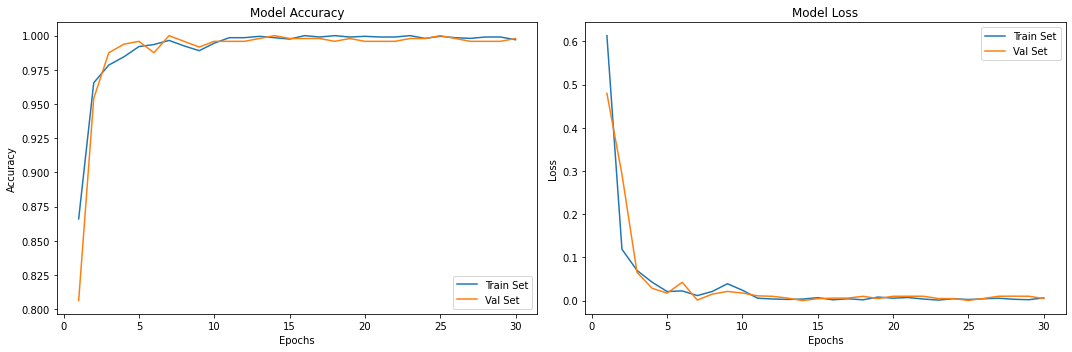

In [34]:
acc = efficientnet_history.history['accuracy']
val_acc = efficientnet_history.history['val_accuracy']
loss = efficientnet_history.history['loss']
val_loss = efficientnet_history.history['val_loss']
epochs_range = range(1, len(efficientnet_history.epoch) + 1)
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.tight_layout()
plt.show()

In [35]:
from tensorflow.keras.models import load_model
model = load_model('./EfficientNetB2_cropping+equalization.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b2 (Functional) (None, 7, 7, 1408)        7768562   
_________________________________________________________________
global_max_pooling2d (Global (None, 1408)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1408)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1409      
Total params: 7,769,971
Trainable params: 7,702,403
Non-trainable params: 67,568
_________________________________________________________________


Val Accuracy =  0.9983333333333333


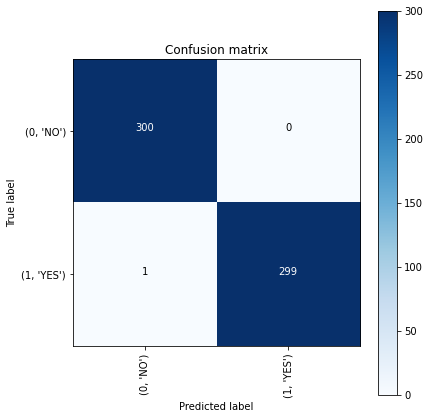

In [36]:
predictions = efficientnet.predict(X_val_crop_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = ' , accuracy)

confusion_mtx = confusion_matrix(y_val, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

Test Accuracy  0.9975


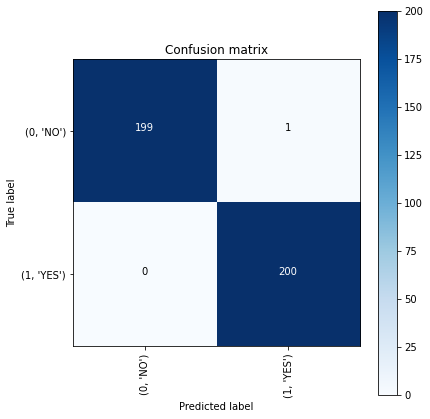

In [37]:
# validate on test set
predictions = efficientnet.predict(X_test_crop_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy ', accuracy)

confusion_mtx = confusion_matrix(y_test, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

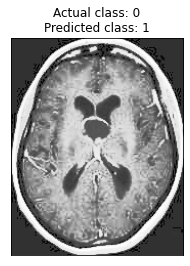

In [38]:
ind_list = np.argwhere((y_test == predictions) == False)[:, -1]
print
if ind_list.size == 0:
    print('There are no missclassified images.')
else:
    for i in ind_list:
        plt.figure()
        plt.imshow(X_test_crop[i])
        plt.xticks([])
        plt.yticks([])
        plt.title(f'Actual class: {y_val[i]}\nPredicted class: {predictions[i]}')
        plt.show()

Val Accuracy  0.9920948616600791


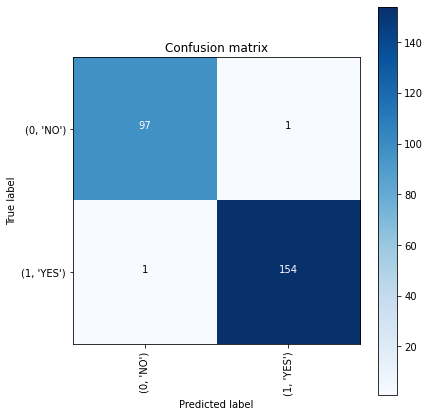

In [39]:
predictions = efficientnet.predict(X_test_bmi_crop_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test_bmi, predictions)
print('Val Accuracy ', accuracy)

confusion_mtx = confusion_matrix(y_test_bmi, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

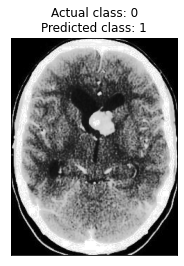

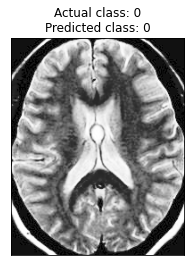

In [40]:
ind_list = np.argwhere((y_test_bmi == predictions) == False)[:, -1]
print
if ind_list.size == 0:
    print('There are no missclassified images.')
else:
    for i in ind_list:
        plt.figure()
        plt.imshow(X_test_bmi_crop[i])
        plt.xticks([])
        plt.yticks([])
        plt.title(f'Actual class: {y_val[i]}\nPredicted class: {predictions[i]}')
        plt.show()

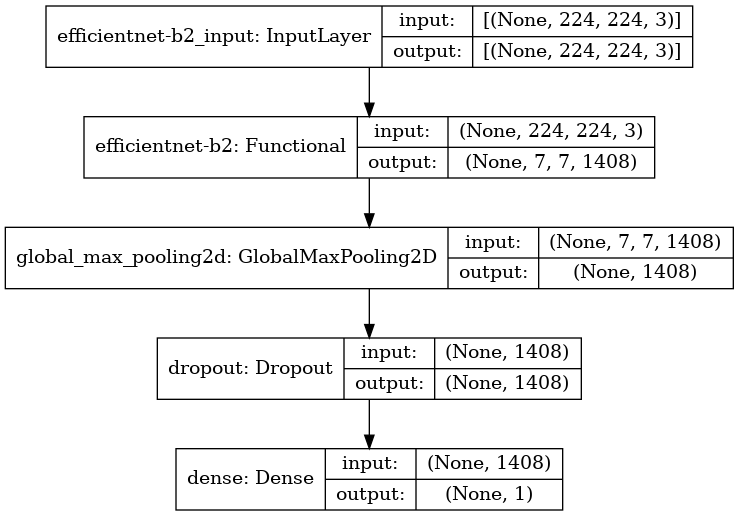

In [41]:
from tensorflow.keras.utils import plot_model
plot_model(model,'model.png',show_shapes=True)

In [42]:
print("Length of y_val:", len(y_val))
print("Length of predictions:", len(predictions))


Length of y_val: 600
Length of predictions: 253


In [43]:
from sklearn.metrics import classification_report
classification_rep = classification_report(y_test_bmi, predictions, target_names=['NO', 'YES'])
print("Classification Report for Test BMI Set:")
print(classification_rep)

Classification Report for Test BMI Set:
              precision    recall  f1-score   support

          NO       0.99      0.99      0.99        98
         YES       0.99      0.99      0.99       155

    accuracy                           0.99       253
   macro avg       0.99      0.99      0.99       253
weighted avg       0.99      0.99      0.99       253



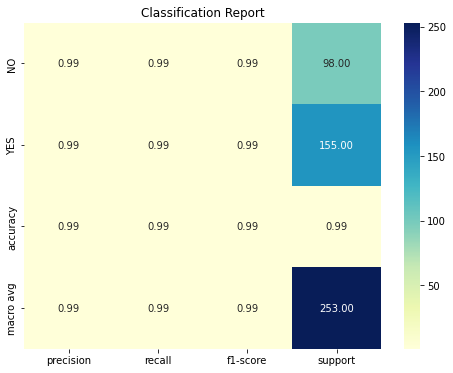

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
classification_rep = classification_report(y_test_bmi, predictions, target_names=['NO', 'YES'], output_dict=True)
classification_df = pd.DataFrame(classification_rep).transpose()
plt.figure(figsize=(8, 6))
sns.heatmap(classification_df.iloc[:-1, :].astype(float), annot=True, cmap="YlGnBu", fmt=".2f")
plt.title('Classification Report')
plt.show()

Processing /kaggle/input/brain-tumor-detection


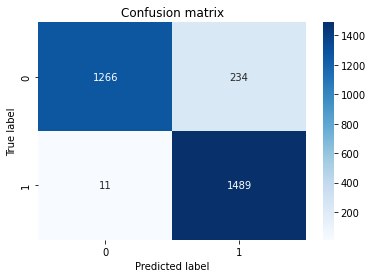

Processing /kaggle/input/brain-mri-images-for-brain-tumor-detection


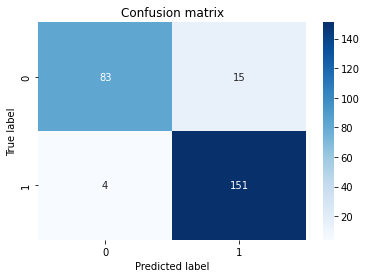

In [48]:
import os
import cv2
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
def load_and_preprocess_images(directory, img_size):
    X = []
    y = []
    labels = {'yes': 1, 'no': 0}
    for label in ['yes', 'no']:
        path = os.path.join(directory, label)
        class_num = labels[label]
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img))
                new_array = cv2.resize(img_array, img_size)
                X.append(new_array)
                y.append(class_num)
            except Exception as e:
                pass
    return np.array(X), np.array(y)

def plot_confusion_matrix(cm, classes, title='Confusion matrix'):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
model = load_model('./EfficientNetB2_cropping+equalization.h5')
directories = [
    '/kaggle/input/brain-tumor-detection',
    '/kaggle/input/brain-mri-images-for-brain-tumor-detection',
]
IMG_SIZE = (224, 224)
for directory in directories:
    print(f"Processing {directory}")
    X, y = load_and_preprocess_images(directory, IMG_SIZE)
    X_prep = resize_imgs(X, IMG_SIZE)  
    predictions = model.predict(X_prep)
    predictions = [1 if x > 0.5 else 0 for x in predictions]
    cm = confusion_matrix(y, predictions)
    plot_confusion_matrix(cm, ['NO', 'YES'])    

Processing /kaggle/input/bd-braintumor/Tumeur_cerveau/test


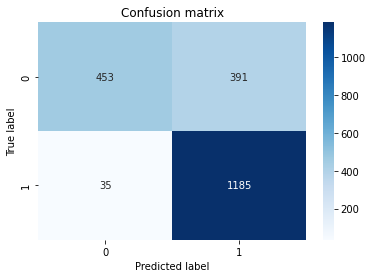

In [49]:
import os
import cv2
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def load_and_preprocess_images(directory, img_size):
    X = []
    y = []
    labels = {'1': 1, '2': 0} 
    for label in ['1', '2']:
        path = os.path.join(directory, label)
        class_num = labels[label]
        for img in os.listdir(path):
            try:
                img_array = cv2.imread(os.path.join(path, img))
                new_array = cv2.resize(img_array, img_size)
                X.append(new_array)
                y.append(class_num)
            except Exception as e:
                pass
    return np.array(X), np.array(y)

def plot_confusion_matrix(cm, classes, title='Confusion matrix'):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
model = load_model('./EfficientNetB2_cropping+equalization.h5')
directory = '/kaggle/input/bd-braintumor/Tumeur_cerveau/test'
IMG_SIZE = (224, 224)
print(f"Processing {directory}")
X, y = load_and_preprocess_images(directory, IMG_SIZE)
X_prep = resize_imgs(X, IMG_SIZE)  
predictions = model.predict(X_prep)
predictions = [1 if x > 0.5 else 0 for x in predictions]
cm = confusion_matrix(y, predictions)
plot_confusion_matrix(cm, ['NO', 'YES'])